## SparceSC

Synthetic Control via Regularized (Sparse) Optimization - Ben-Michael, Feller & Rothstein (2021)

* Ambiente virtual: venv-sparses
* https://sparsesc.readthedocs.io/en/latest/

---

***SC***

In [38]:
import numpy as np
import pandas as pd
import SparseSC as SC

# 1) Dados
df = pd.read_csv("https://github.com/Daniel-Uhr/data/raw/main/california_prop99.csv", delimiter=";")
Y = df.pivot(index="State", columns="Year", values="PacksPerCapita")

# 2) Vetor de tratamento: NaN p/ controles; índice da 1a coluna pós p/ California
utp = np.full(Y.shape[0], np.nan)
utp[Y.index.get_loc("California")] = np.where(Y.columns == 1989)[0][0]

# 3) Synthetic DID-style com placebos internos
res = SC.estimate_effects(
    outcomes=Y.values,
    unit_treatment_periods=utp,
    fast=True,          # use o caminho “separate/fast” (estável)
    level=0.95,         # nível do IC
    max_n_pl=50,       # nº de placebos simulados
    ret_pl=True,        # <- peça para retornar os placebos
    ret_CI=True         # <- e intervalos
)

print(res)  # imprime ATT

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:626: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.95366771641784, tolerance: 21.491984569567364
  model = cd_fast.enet_coordinate_descent_multi_task(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:626: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.946997609346, tolerance: 21.491984569567364
  model = cd_fast.enet_coordinate_descent_multi_task(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:626: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.6422740946291, tolerance: 21.49198456

Pre-period fit diagnostic: Were the treated harder to match in the pre-period than the controls were.
Average difference in outcome for pre-period between treated and SC unit (concerning if p-value < 0.050000000000000044 ): 
1.8901867201458566 (p-value: 0.9743589743589743)

(Investigate per-period match quality more using self.pl_res_pre.effect_vec)

Average Effect Estimation: -17.574912173508324 (p-value: 0.10256410256410256)

Effect Path Estimation:
 -4.650533003036472 (p-value: 0.1794871794871795)
-3.1811748035699026 (p-value: 0.5384615384615384)
-9.071452004769583 (p-value: 0.2564102564102564)
-9.012376867937022 (p-value: 0.3333333333333333)
-14.315229170669639 (p-value: 0.20512820512820512)
-18.594962109231844 (p-value: 0.1282051282051282)
-20.87536499893355 (p-value: 0.1794871794871795)
-22.30770753729753 (p-value: 0.15384615384615385)
-23.4602319860875 (p-value: 0.20512820512820512)
-25.994207103722637 (p-value: 0.15384615384615385)
-30.217980269185837 (p-value: 0.05128205128205

In [39]:
def ci_bounds(ci_obj):
    # tenta vários nomes comuns para os limites inferior/superior
    low = None
    high = None
    for name in ("low","lo","lower","lb","l","L","Lower","Lo","Low"):
        if hasattr(ci_obj, name):
            low = getattr(ci_obj, name)
            break
    for name in ("high","hi","upper","ub","u","U","Upper","Hi","High"):
        if hasattr(ci_obj, name):
            high = getattr(ci_obj, name)
            break
    # fallback: se o objeto for indexável ou tiver método de conversão
    if (low is None or high is None):
        if hasattr(ci_obj, "as_tuple"):
            return ci_obj.as_tuple()
        try:
            return (ci_obj[0], ci_obj[1])
        except Exception:
            pass
    return (low, high)


In [40]:
te = res.pl_res_post.avg_joint_effect

ATT = te.effect
CI_obj = te.ci
p  = te.p
pls = np.asarray(te.placebos)

lo, hi = ci_bounds(CI_obj)
SE = (hi - lo) / (2 * 1.96) if (lo is not None and hi is not None) else None

print(f"ATT: {ATT}")
print(f"SE : {SE}")
print(f"IC : ({lo}, {hi})")
print(f"p  : {p}")
print(f"N placebos: {len(pls)}")


ATT: -17.574912173508324
SE : None
IC : (None, None)
p  : 0.10256410256410256
N placebos: 38


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ====== 0) Insumos ======
# - res: retornado por SparseSC.estimate_effects(...)
# - Y  : DataFrame pivotado (State x Year), já usado na estimação
# ================================================

# 1) Identificar tratado e tempos a partir do objeto
treated = int(np.where(~np.isnan(res.unit_treatment_periods))[0][0])  # assume 1 tratado
T0 = res.T0                       # nº de colunas de pré
years = Y.columns.to_numpy()      # anos do seu DataFrame (preferível manter os seus)
treat_cut_year = years[T0]        # primeiro ano tratado (ex.: 1989)
pre_last_year  = years[T0-1]      # último ano de pré (ex.: 1988)

# 2) Observado e sintético completos (pré + pós) a partir do res
Y_obs = res.Y                     # N x T (observado), na ordem usada em res
Y_sc  = res.get_sc()              # N x T (sintético), mesma ordem
y_real = Y_obs[treated, :]
y_synth = Y_sc[treated, :]
gap = y_real - y_synth

# 3) DataFrame com a trajetória completa
traj = pd.DataFrame({
    "year": years,
    "real": y_real,
    "synthetic": y_synth,
    "gap": gap
})
print(traj)

    year        real   synthetic        gap
0   1970  123.000000  122.522634   0.477366
1   1971  121.000000  125.085607  -4.085607
2   1972  123.500000  129.381047  -5.881047
3   1973  124.400002  126.118555  -1.718554
4   1974  126.699997  125.593445   1.106551
5   1975  127.099998  125.249738   1.850260
6   1976  128.000000  129.232730  -1.232730
7   1977  126.400002  126.562957  -0.162955
8   1978  126.099998  124.701273   1.398726
9   1979  121.900002  121.458747   0.441255
10  1980  120.199997  119.052611   1.147386
11  1981  118.599998  119.094351  -0.494353
12  1982  115.400002  116.150300  -0.750299
13  1983  110.800003  112.187932  -1.387929
14  1984  104.800003  105.090423  -0.290420
15  1985  102.800003  102.022946   0.777057
16  1986   99.699997   99.205964   0.494032
17  1987   97.500000   97.510701  -0.010701
18  1988   90.099998   90.408779  -0.308781
19  1989   82.400002   87.050535  -4.650533
20  1990   77.800003   80.981178  -3.181175
21  1991   68.699997   77.771449

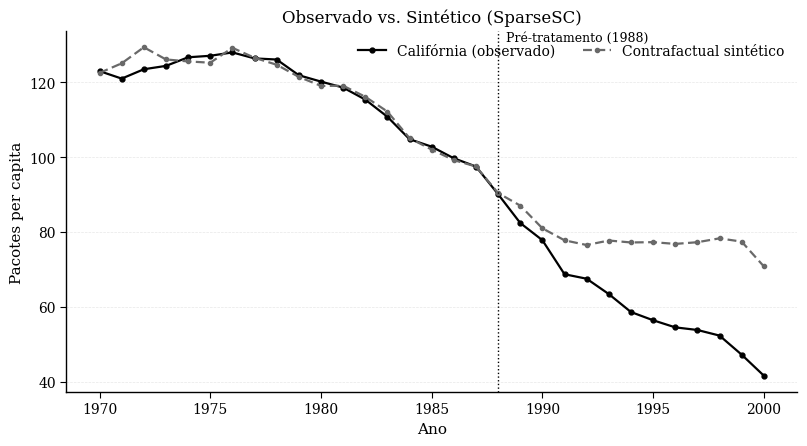

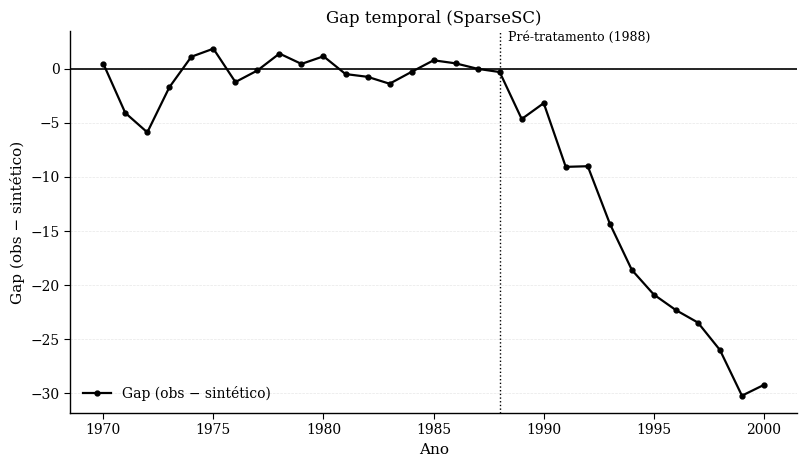

In [42]:
# ===== Estilo AER (monocromático, clean) =====
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    # fontes e tamanhos
    "font.family": "serif",
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    # linhas e grades
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.0,
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "grid.alpha": 0.3,
    # ticks “para fora”
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    # sem transparências estranhas
    "savefig.transparent": False,
})

# Paleta monocromática
col_real = "black"
col_synth = "dimgray"
col_gap = "black"

# ===== Gráfico 1 — Observado vs. Sintético (AER style) =====
fig, ax = plt.subplots(figsize=(8.2, 4.6))  # proporção mais “paper”
ax.plot(years, y_real, "-o", color=col_real, linewidth=1.6, markersize=3.5, label="Califórnia (observado)")
ax.plot(years, y_synth, "--o", color=col_synth, linewidth=1.6, dashes=(4,2), markersize=3.0, label="Contrafactual sintético")

# linha vertical no último ano de pré
ax.axvline(pre_last_year, color="black", linestyle=":", linewidth=1.0)
ax.text(pre_last_year, ax.get_ylim()[1], f"  Pré-tratamento ({pre_last_year})",
        va="top", ha="left", fontsize=9)

ax.set_xlabel("Ano")
ax.set_ylabel("Pacotes per capita")
ax.set_title("Observado vs. Sintético (SparseSC)")
ax.grid(True, axis="y")
ax.legend(frameon=False, ncol=2, loc="upper right")

fig.tight_layout()
plt.show()

# ===== Gráfico 2 — Gap temporal (obs − sintético) (AER style) =====
fig, ax = plt.subplots(figsize=(8.2, 4.8))
ax.axhline(0, color="black", linewidth=1.2)  # baseline mais espessa

ax.plot(years, gap, "-o", color=col_gap, linewidth=1.6, markersize=3.5, label="Gap (obs − sintético)")

ax.axvline(pre_last_year, color="black", linestyle=":", linewidth=1.0)
ax.text(pre_last_year, ax.get_ylim()[1], f"  Pré-tratamento ({pre_last_year})",
        va="top", ha="left", fontsize=9)

ax.set_xlabel("Ano")
ax.set_ylabel("Gap (obs − sintético)")
ax.set_title("Gap temporal (SparseSC)")
ax.grid(True, axis="y")
ax.legend(frameon=False, loc="lower left")

fig.tight_layout()
plt.show()


In [37]:
# ============================================================
# State − Synthetic Across Time (Placebos) com SparseSC
#   • reaproveita penalidades do ajuste principal (rápido)
#   • filtra outliers por banda 2·sd(t)
#   • estilo “paper” (monocromático, clean)
# Requer: res (de SparseSC.estimate_effects), Y (State×Year), years
# ============================================================
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from contextlib import redirect_stdout
import SparseSC as SC

# ---- estilo AER monocromático ----
mpl.rcParams.update({
    "font.family": "serif", "font.size": 11,
    "axes.titlesize": 12, "axes.labelsize": 11,
    "xtick.labelsize": 10, "ytick.labelsize": 10,
    "legend.fontsize": 10, "axes.spines.top": False,
    "axes.spines.right": False, "axes.linewidth": 1.0,
    "grid.linestyle": "--", "grid.linewidth": 0.5, "grid.alpha": 0.3,
    "xtick.direction": "out", "ytick.direction": "out",
    "xtick.major.size": 4, "ytick.major.size": 4
})

# ---------- 0) Insumos básicos do objeto ----------
treated = int(np.where(~np.isnan(res.unit_treatment_periods))[0][0])
T0 = res.T0
pre_mask  = years <= years[T0-1]
post_mask = years >  years[T0-1]
pre_last_year = years[T0-1]

# Gap da Califórnia direto do objeto (contrafactual completo)
Y_obs = res.Y
Y_sc  = res.get_sc()
gap_ca = Y_obs[treated, :] - Y_sc[treated, :]

# ---------- 1) Construir placebos (rápido) se não existir ----------
try:
    placebo_gaps
except NameError:
    v_pen0 = res.fit.fitted_v_pen
    w_pen0 = res.fit.fitted_w_pen
    N = Y.shape[0]
    controls_idx = [i for i in range(N) if i != treated]
    placebo_gaps = []

    with open(os.devnull, "w") as f, redirect_stdout(f):
        for c in controls_idx:
            m_pl = SC.fit(
                features=Y.loc[:, pre_mask].values,
                targets =Y.loc[:, post_mask].values,
                treated_units=[c],
                v_pen=v_pen0, w_pen=w_pen0  # penalidades fixas → sem CV
            )
            ctrl_idx_pl = np.array(m_pl.control_units, dtype=int)
            w_c = m_pl.sc_weights[c, :]
            Y_synth_full_c = w_c @ Y.values[ctrl_idx_pl, :]
            diff_c = Y.values[c, :] - Y_synth_full_c
            placebo_gaps.append(diff_c)

    placebo_gaps = np.vstack(placebo_gaps)  # (#placebos × T)

# ---------- 2) Filtro 2·sd(t) e plot ----------
sd_by_t = placebo_gaps.std(axis=0, ddof=1)
mask_ok = np.all(np.abs(placebo_gaps) <= (2 * sd_by_t), axis=1)
placebos_to_plot = placebo_gaps[mask_ok] if np.any(mask_ok) else placebo_gaps

fig, ax = plt.subplots(figsize=(12, 6))

# placebos em cinza claro
for diff in placebos_to_plot:
    ax.plot(years, diff, color="lightgray", linewidth=0.8, alpha=0.7, zorder=1)

# Califórnia destacada
ax.plot(years, gap_ca, "-", color="steelblue", linewidth=1.8, label="California", zorder=2)

# referências
ax.axvline(pre_last_year, color="black", linestyle=":", linewidth=1.0, label="Proposition 99")
ax.axhline(0, color="black", linewidth=1.2)

# rótulos e título
ax.set_ylabel("Gap in per-capita cigarette sales (in packs)")
ax.set_xlabel("Year")
ax.set_title("State − Synthetic Across Time")
ax.legend(frameon=False, loc="upper left")
ax.grid(True, axis="y")

fig.tight_layout()
plt.show()


AttributeError: 'NoneType' object has no attribute 'std'

In [1]:
# -------------------------------------------------------
# SparseSC - de forma silenciosa
# -------------------------------------------------------

import sys, os
import numpy as np
import pandas as pd
import SparseSC as SC
from contextlib import redirect_stdout

# -------------------------------------------------------
# 1) Dados
# -------------------------------------------------------
df = pd.read_csv("https://github.com/Daniel-Uhr/data/raw/main/california_prop99.csv", delimiter=";")
Y = df.pivot(index="State", columns="Year", values="PacksPerCapita")
treated_idx = [Y.index.get_loc("California")]
pre  = (Y.columns <= 1988)
post = (Y.columns >  1988)

# -------------------------------------------------------
# 2) Ajuste silencioso (sem prints internos)
# -------------------------------------------------------
with open(os.devnull, "w") as f, redirect_stdout(f):
    model = SC.fit(
        features=Y.loc[:, pre].values,
        targets=Y.loc[:, post].values,
        treated_units=treated_idx
    )

# -------------------------------------------------------
# 3) ATT
# -------------------------------------------------------
Yhat_post = model.predict()
att_mean = (Y.iloc[treated_idx[0], post].values - Yhat_post[treated_idx[0], :]).mean()
print(f"ATT médio (pós-1988) — SparseSC: {att_mean:.3f}")

Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>>>>>>>>>>>>| 
ATT médio (pós-1988) — SparseSC: -24.587


c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [2]:
att_mean

-24.58738246357144

***Análise Gráfica***
* Trajetórias Real vs Sintética
* Diferença das Trajetórias

    year        real   synthetic        gap
0   1970  123.000000  112.921503  10.078497
1   1971  121.000000  116.377943   4.622057
2   1972  123.500000  122.192799   1.307201
3   1973  124.400002  122.695901   1.704100
4   1974  126.699997  124.073175   2.626822
5   1975  127.099998  125.175036   1.924963
6   1976  128.000000  128.984338  -0.984338
7   1977  126.400002  127.172497  -0.772496
8   1978  126.099998  125.255413   0.844586
9   1979  121.900002  122.258133  -0.358132
10  1980  120.199997  120.845202  -0.645205
11  1981  118.599998  120.384219  -1.784220
12  1982  115.400002  118.278950  -2.878948
13  1983  110.800003  113.777237  -2.977234
14  1984  104.800003  107.281500  -2.481497
15  1985  102.800003  105.092731  -2.292728
16  1986   99.699997  102.641763  -2.941766
17  1987   97.500000  100.566742  -3.066742
18  1988   90.099998   96.326508  -6.226510
19  1989   82.400002   92.730771 -10.330769
20  1990   77.800003   88.510111 -10.710108
21  1991   68.699997   86.141336

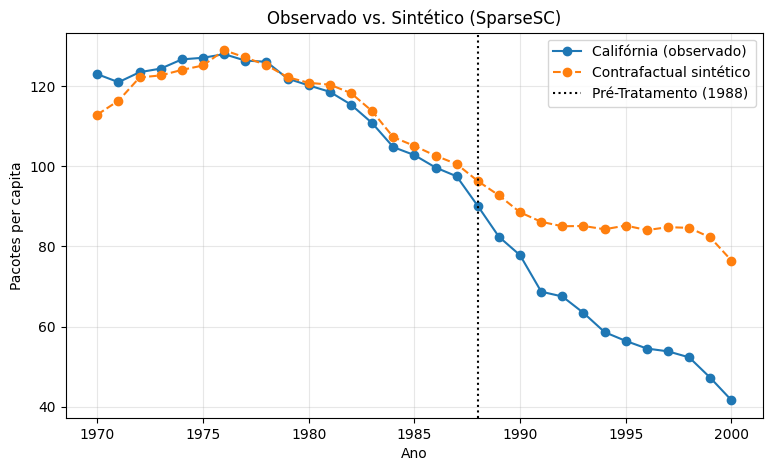

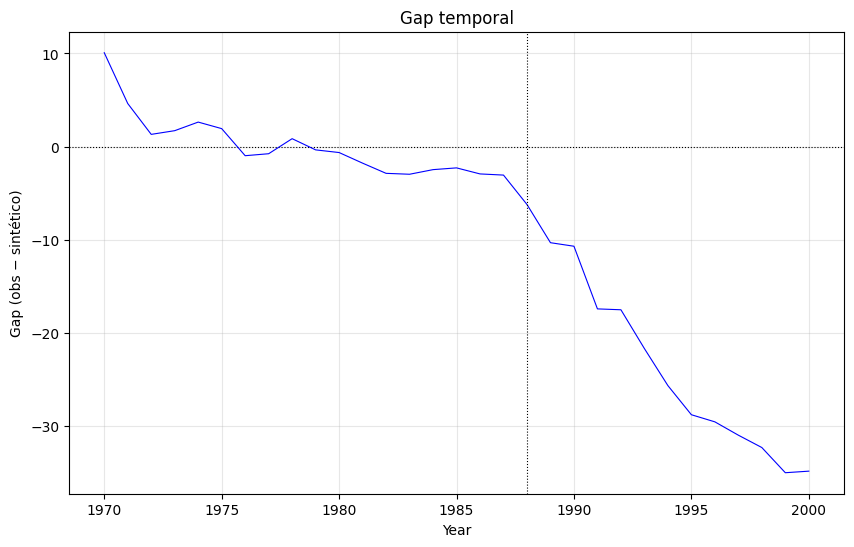

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

treated = treated_idx[0]
years   = Y.columns.to_numpy()

# 1) Pegue os índices dos controles e os pesos da unidade tratada
control_idx = np.array(model.control_units, dtype=int)  # índices das linhas de controle em Y
w = model.sc_weights[treated, :]                        # pesos do tratado sobre os controles

# 2) Reconstrua o sintético em TODO o período (pré + pós) de uma vez
Y_controls_all = Y.values[control_idx, :]               # matriz (N_ctrl x T)
Y_synth_full   = w @ Y_controls_all                     # vetor (T,)

# 3) Observado do tratado
Y_real = Y.iloc[treated, :].values

# 4) (opcional) DataFrame com série completa e gap
traj = pd.DataFrame({
    "year": years,
    "real": Y_real,
    "synthetic": Y_synth_full,
    "gap": Y_real - Y_synth_full,
})

# Tabela 
print(traj)

# 5) Gráfico: observado vs sintético
plt.figure(figsize=(9,5))
plt.plot(years, Y_real, "-o", label="Califórnia (observado)")
plt.plot(years, Y_synth_full, "--o", label="Contrafactual sintético")
plt.axvline(1988, color="k", linestyle=":", label="Pré-Tratamento (1988)")
plt.xlabel("Ano"); plt.ylabel("Pacotes per capita"); plt.title("Observado vs. Sintético (SparseSC)")
plt.legend(); plt.grid(alpha=.3); plt.show()

# 6) (opcional) Diferença temporal (gap)
plt.figure(figsize=(10, 6))
plt.axhline(0, color='black', linestyle=":", lw=0.8)
plt.plot(years, traj["gap"].values, color='blue', linewidth=0.8)
plt.axvline(1988, color='black', linestyle=":", lw=0.8, label="Proposition 99")
plt.xlabel("Year"); plt.ylabel("Gap (obs − sintético)"); plt.title("Gap temporal")
plt.grid(alpha=.3); plt.show()

***Teste de Placebo***

In [9]:
import numpy as np
import os
from contextlib import redirect_stdout

treated = treated_idx[0]                      # índice da Califórnia em Y
controls = [i for i in range(Y.shape[0]) if i != treated]

# Penalidades do 1º ajuste (para evitar CV a cada placebo)
v_pen0 = model.fitted_v_pen
w_pen0 = model.fitted_w_pen

placebo_atts = []
placebo_gaps = []

for c in controls:
    # 1) rodar o fit do placebo c, mas EXCLUINDO a Califórnia do doador
    with open(os.devnull, "w") as f, redirect_stdout(f):
        # Primeiro chamamos um fit “rascunho” só para descobrir a ordem de control_units
        m_tmp = SC.fit(
            features=Y.loc[:, pre].values,
            targets=Y.loc[:, post].values,
            treated_units=[c],
            v_pen=v_pen0, w_pen=w_pen0
        )
        ctrl_idx_tmp = np.array(m_tmp.control_units, dtype=int)

        # Montar custom_donor_pool (N x C): por padrão permite todos os controles...
        base_cdp = (1 - np.eye(Y.shape[0]))[:, ctrl_idx_tmp].astype(bool)
        # ...mas pro placebo c, ZERAMOS a coluna correspondente à Califórnia (se ela estiver nos controles)
        if treated in ctrl_idx_tmp:
            col_cal = int(np.where(ctrl_idx_tmp == treated)[0][0])  # posição da Califórnia dentro dos controles
            base_cdp[c, col_cal] = False

        # Agora refazemos o fit com a donor pool restrita
        m_pl = SC.fit(
            features=Y.loc[:, pre].values,
            targets=Y.loc[:, post].values,
            treated_units=[c],
            v_pen=v_pen0, w_pen=w_pen0,
            custom_donor_pool=base_cdp
        )

    # 2) ATT placebo (pós) usando apenas o modelo m_pl final
    Yhat_post_pl = m_pl.predict()  # N x T_pos
    att_pl = (Y.iloc[c, post].values - Yhat_post_pl[c, :]).mean()
    placebo_atts.append(att_pl)

    # 3) Gap COMPLETO (pré + pós) do placebo c (com a donor pool correta)
    ctrl_idx_pl = np.array(m_pl.control_units, dtype=int)
    w_c = m_pl.sc_weights[c, :]                        # pesos do “tratado” c sobre seus controles
    Y_synth_full_c = w_c @ Y.values[ctrl_idx_pl, :]    # trajetória sintética completa
    diff_c = Y.values[c, :] - Y_synth_full_c
    placebo_gaps.append(diff_c)

placebo_atts = np.array(placebo_atts)
placebo_gaps = np.vstack(placebo_gaps)


c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


IndexError: index 38 is out of bounds for axis 0 with size 1

Gráfico:

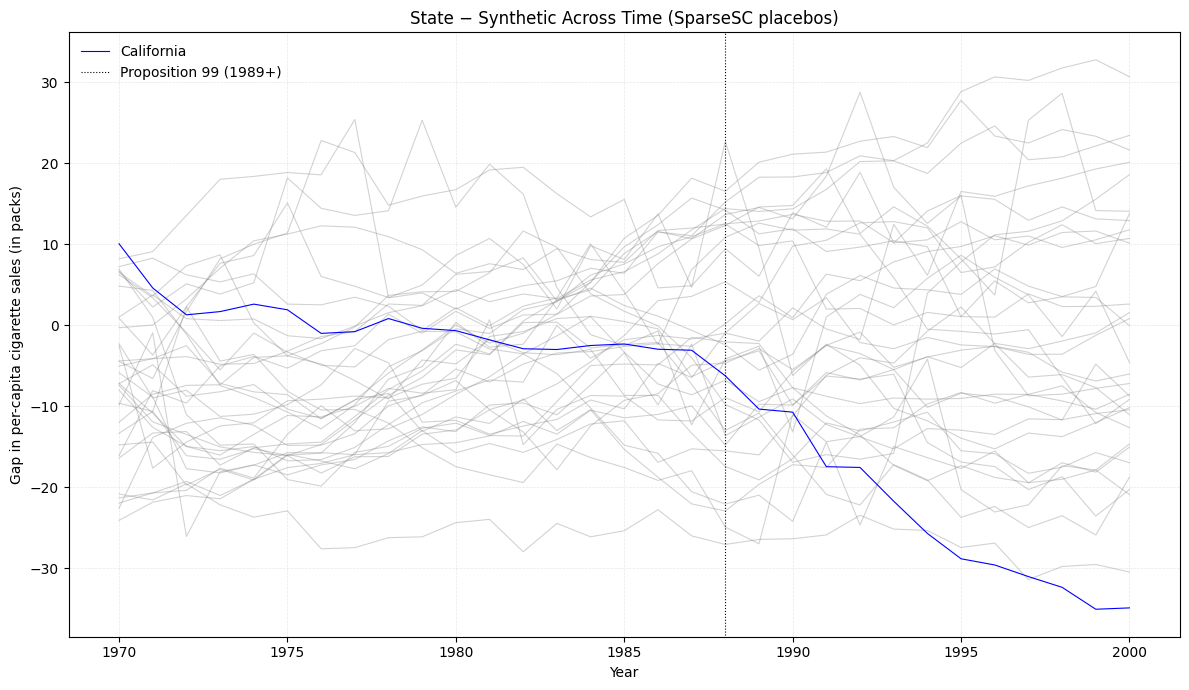

In [8]:
# ==========================================
# Reconstrução do gap da Califórnia (gap_ca)
# ==========================================

treated = treated_idx[0]
control_idx = np.array(model.control_units, dtype=int)
w_ca = model.sc_weights[treated, :]                   # pesos da Califórnia sobre os controles
Y_controls_all = Y.values[control_idx, :]             # matriz (N_ctrl x T)
Y_synth_full_ca = w_ca @ Y_controls_all               # trajetória sintética completa
gap_ca = Y.iloc[treated, :].values - Y_synth_full_ca  # diferença observada - sintética


import numpy as np
import matplotlib.pyplot as plt

# ----- Assumindo já existentes em memória -----
# gap_ca         -> vetor (T,) com o gap da Califórnia (obs - sintético, pré+pós)
# placebo_gaps   -> matriz (#placebos x T) com gaps dos placebos (pré+pós)
# years          -> array/lista de anos (T,)
# ------------------------------------------------

# Desvio-padrão ponto-a-ponto dos placebos (para filtragem opcional)
std_dev_by_t = placebo_gaps.std(axis=0, ddof=1)

# ===============================
# Gráfico de Placebos (estilo SDID)
# ===============================
plt.figure(figsize=(12, 7))

# Placebos (cinza claro, mais suaves)
for diff_c in placebo_gaps:
    # opcional: excluir trajetórias com |gap| > 2 * sd em algum ponto
    if np.all(np.abs(diff_c) <= 2 * std_dev_by_t):
        plt.plot(years, diff_c, color="gray", alpha=0.35, linewidth=0.8)

# Califórnia — linha principal
plt.plot(years, gap_ca, label="California", color='blue', linewidth=0.8)

# Linhas de referência
plt.axvline(x=1988, ymin=-50, ymax=120, color='black', linestyle=":", lw=0.8, label="Proposition 99 (1989+)")
plt.axhline(y=0, xmin=1970, xmax=2000, color='black', lw=3)

# Layout e rótulos no estilo SDID
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.xlabel("Year")
plt.title("State − Synthetic Across Time (SparseSC placebos)")
plt.legend(frameon=False)
plt.grid(alpha=0.3, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()



In [ ]:

# 2) EVENT STUDY COM IC 95% (via placebos)
treat_year = 1989
event_time = np.asarray(years) - treat_year

tau_t  = gap_ca
sd_t   = placebo_gaps.std(axis=0, ddof=1)       # mesma base dos placebos
ci_low  = tau_t - 1.96 * sd_t
ci_high = tau_t + 1.96 * sd_t

plt.figure(figsize=(10,6))
plt.axhline(0, color="black", linewidth=1)
plt.axvline(0, color="black", linestyle="--", label="Tratamento (1989)")

plt.fill_between(event_time, ci_low, ci_high, color='skyblue', alpha=0.3, label="IC 95% (placebos)")
plt.plot(event_time, tau_t, '-o', color='blue', label="Gap (Califórnia − Sintético)")

plt.xlabel("Tempo relativo ao tratamento (anos)")
plt.ylabel("Diferença em vendas per capita (pacotes)")
plt.title("Event Study – Controle Sintético (California Prop 99)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# ============================================
# Gráfico de Placebos – "State − Synthetic Across Time"
# ============================================

import matplotlib.pyplot as plt
import numpy as np

years = Y.columns.to_numpy()

# Gap da Califórnia (observado - sintético)
control_idx = np.array(model.control_units, dtype=int)
w_ca = model.sc_weights[treated, :]
Y_controls_all = Y.values[control_idx, :]
Y_synth_full_ca = w_ca @ Y_controls_all
gap_ca = Y.iloc[treated, :].values - Y_synth_full_ca

# Desvio padrão ponto-a-ponto dos placebos (para filtragem)
std_dev_by_t = placebo_gaps.std(axis=0, ddof=1)

plt.figure(figsize=(12, 7))

# Plotar os gaps de cada placebo (cinza claro)
for diff_c in placebo_gaps:
    # Opcional: filtrar trajetórias muito fora da curva (|gap| > 2σ)
    if np.all(np.abs(diff_c) <= 2 * std_dev_by_t):
        plt.plot(years, diff_c, color="gray", alpha=0.35, linewidth=0.8)

# Plotar o gap da Califórnia (azul mais espesso)
plt.plot(years, gap_ca, label="California", color='blue', linewidth=1.8)

# Marcar o ano do tratamento
plt.axvline(x=1988, color='black', linestyle=":", lw=0.9, label="Proposition 99 (1989+)")
plt.axhline(y=0, color='black', lw=1)

plt.ylabel("Gap (observado − sintético), pacotes per capita")
plt.xlabel("Ano")
plt.title("State − Synthetic Across Time (SparseSC placebos)")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


***Teste de Placebo***

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from contextlib import redirect_stdout

# --- Inferência por placebos (reaproveitando seu loop) ---
N = Y.shape[0]
treated = treated_idx[0]
controls = [i for i in range(N) if i != treated]

placebo_atts = []
placebo_gaps = []   # <<— novo: guardará o gap (pré+pós) de cada placebo

for c in controls:
    # opcional: silenciar prints internos do fit
    with open(os.devnull, "w") as f, redirect_stdout(f):
        m_pl = SC.fit(
            features=Y.loc[:, pre].values,
            targets=Y.loc[:, post].values,
            treated_units=[c]
        )

    # ATT do placebo (pós), como você já fazia:
    Yhat_post_pl = m_pl.predict()
    att_pl = (Y.iloc[c, post].values - Yhat_post_pl[c, :]).mean()
    placebo_atts.append(att_pl)

    # <<— NOVO: série sintética COMPLETA para esse controle c
    ctrl_idx_pl = np.array(m_pl.control_units, dtype=int)
    w_c = m_pl.sc_weights[c, :]                     # pesos do "tratado" c sobre os controles do m_pl
    Y_controls_all_pl = Y.values[ctrl_idx_pl, :]    # (N_ctrl_pl x T)
    Y_synth_full_c = w_c @ Y_controls_all_pl        # (T,)
    diff_c = Y.iloc[c, :].values - Y_synth_full_c   # gap pré+pós do placebo c
    placebo_gaps.append(diff_c)

placebo_atts = np.array(placebo_atts)
placebo_gaps = np.vstack(placebo_gaps)              # (N_controls x T)

# Erro-padrão dos ATT placebos (como você já tinha)
std_error = placebo_atts.std(ddof=1)
t_stat = att_mean / std_error if std_error > 0 else np.nan
p_value = (np.sum(np.abs(placebo_atts) >= np.abs(att_mean)) + 1) / (len(placebo_atts) + 1)

# IC 95% normal
import scipy.stats as st
z = st.norm.ppf(0.975)
ci_norm = (att_mean - z * std_error, att_mean + z * std_error)

print(f"ATT (SC): {att_mean}")
print(f"Erro padrão (SC): {std_error}")
print(f"T-stat (SC): {t_stat}")
print(f"P-valor (SC): {p_value}")
print(f"IC 95% (normal aprox.): {ci_norm}")

# ====== Agora o gráfico estilo “State - Synthetic Across Time” ======

years = Y.columns.to_numpy()

# Gap da Califórnia com a trajetória sintética COMPLETA (reaproveitando seu modelo já estimado)
control_idx = np.array(model.control_units, dtype=int)
w_ca = model.sc_weights[treated, :]
Y_controls_all = Y.values[control_idx, :]
Y_synth_full_ca = w_ca @ Y_controls_all
gap_ca = Y.iloc[treated, :].values - Y_synth_full_ca

# Desvio-padrão ponto-a-ponto dos placebos (para filtragem opcional)
std_dev_by_t = placebo_gaps.std(axis=0, ddof=1)

plt.figure(figsize=(12, 7))

# Placebos "limpos": exclui trajetórias com |gap| > 2 sd em algum ponto
for diff_c in placebo_gaps:
    if np.all(np.abs(diff_c) <= 2 * std_dev_by_t):
        plt.plot(years, diff_c, color="gray", alpha=0.35, linewidth=0.8)

# Califórnia por cima
plt.plot(years, gap_ca, label="California", color='blue', linewidth=1.8)

plt.axvline(x=1988, color='black', linestyle=":", lw=0.9, label="Proposition 99 (1989+)")
plt.axhline(y=0, color='black', lw=1)
plt.ylabel("Gap (observado − sintético), pacotes per capita")
plt.title("State − Synthetic Across Time (SparseSC placebos reaproveitados)")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>>| 


c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>>| 


c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>>| 


c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>>| 


c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>| 


KeyboardInterrupt: 

***Event-Study***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# --- Efeitos anuais (gap da Califórnia já calculado) ---
tau_t = gap_ca
years = np.array(years)
treat_year = 1989

# --- Gap médio e desvio padrão dos placebos por ano ---
sd_t = placebo_gaps.std(axis=0, ddof=1)
ci_low = tau_t - 1.96 * sd_t
ci_high = tau_t + 1.96 * sd_t

# --- Eixo de tempo relativo ao tratamento ---
event_time = years - treat_year

# --- Gráfico estilo Event-Study ---
plt.figure(figsize=(10,6))
plt.axhline(0, color="black", linewidth=1)
plt.axvline(0, color="black", linestyle="--", label="Tratamento (1989)")

plt.fill_between(event_time, ci_low, ci_high, color='skyblue', alpha=0.3, label="IC 95% (placebos)")
plt.plot(event_time, tau_t, '-o', color='blue', label="Gap observado (Califórnia - Sintético)")

plt.xlabel("Tempo relativo ao tratamento (anos)")
plt.ylabel("Diferença em vendas per capita (pacotes)")
plt.title("Event Study – Controle Sintético (California Prop 99)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()